SEAMLESS NAVIGATION EXTENDED KALMAN FILTER (LOOSELY COUPLED)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import navpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import math

df1 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/IMU_trajectory1.csv', header=0)
df = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/GT_trajectory1.csv', header=0)
df2 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/DVL_trajectory1.csv', header=0)

# df1 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/IMU_trajectory1.csv', header=0)
# df = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/GT_trajectory1.csv', header=0)
# df2 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/DVL_trajectory1.csv', header=0)

vx = df.iloc[:,4]
vy = df.iloc[:,5]
vz=  df.iloc[:,6]

# vx_dvl = t1_org[:,0]
# vy_dvl = t1_org[:,1]
# vz_dvl = t1_org[:,2]

roll = df.iloc[:,7]
pitch = df.iloc[:,8]
yaw = df.iloc[:,9]

lat = df.iloc[:,2]
long = df.iloc[:,1]
alt = df.iloc[:,3]

ax1=df1.iloc[:,1]
ay1=df1.iloc[:,2]
az1=df1.iloc[:,3]

gyro_x1 = df1.iloc[:,4]
gyro_y1 = df1.iloc[:,5]
gyro_z1 = df1.iloc[:,6]

dvl_x = df2.iloc[:,1]
dvl_y = df2.iloc[:,2]
dvl_z = df2.iloc[:,3]

random.seed(42)

def skew_sym(x):
    a = np.array([[0, -x[2], x[1]],
                 [x[2], 0, -x[0]],
                 [-x[1], x[0], 0]])
    return a


In [2]:
### USE THIS TO CONVERT VELOCITIED FROM BODY FRAME TO NAVIGATION FRAME IF YOU ARE GIVING PREDICTED VELOCITIES (USING MNN, FAN, ETC) AS INPUTS ###

# v_converted=[]
# v_dvl = np.column_stack((vx_dvl, vy_dvl, vz_dvl))
# for i in range(400):
    
#     phi = roll[i]
#     theta=pitch[i]
#     si=yaw[i]


#     C_n_b = np.array([[math.cos(theta)*math.cos(si), -math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si)],
#             [math.cos(theta)*math.sin(si), math.cos(phi)*math.cos(si)+math.sin(phi)*math.sin(theta)*math.sin(si), -math.sin(phi)*math.cos(si)+math.cos(phi)*math.sin(theta)*math.sin(si)],
#             [-math.sin(theta), math.sin(phi)*math.cos(theta), math.cos(phi)*math.cos(theta)]])
    
#     # C_n_b_transpose = np.array([[math.cos(theta)*math.cos(si), math.cos(theta)*math.cos(si), -math.sin(theta)],
#     #                             [-math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.cos(theta)],
#     #                             [math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si), -math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si), math.cos(phi)*math.cos(theta)]])

#     C_n_b_inv = np.linalg.inv(C_n_b)
#     v1= (C_n_b) @ v_dvl[i]

# #     diff = abs(v_ned[i]) - abs(v1)
#     v_converted.append(v1)

In [3]:
# vx = np.array(v_converted).T[0]
# vy = np.array(v_converted).T[1]
# vz = np.array(v_converted).T[2]

In [4]:
ax=[]
ay=[]
az=[]
gyro_x=[]
gyro_y=[]
gyro_z=[]
for i in range(len(ax1)):
    if i%100==0:
        ax.append(ax1[i])
        ay.append(ay1[i])
        az.append(az1[i])
        gyro_x.append(gyro_x1[i])
        gyro_y.append(gyro_y1[i])
        gyro_z.append(gyro_z1[i])

gyrosc=np.column_stack((gyro_x,gyro_y,gyro_z))
acc=np.column_stack((ax,ay,az))
v_ned = np.column_stack((vx, vy, vz))
v_dvl_tot = np.column_stack((dvl_x, dvl_y, dvl_z))

In [5]:
north=[]
east=[]
down=[]
for i in range (0, len(lat)):
    arr= navpy.lla2ned(lat[i], long[i], alt[i], 0.573337071406794, 0.6089844335224215, -19.859909, latlon_unit='rad', alt_unit='m', model='wgs84')
    north.append(arr[0])
    east.append(arr[1])
    down.append(arr[2])

ned = np.column_stack((north,east,down))

In [6]:

Ro = 6378137
e = 0.0818191908425

def R_N(L):
    x = Ro * (1-(e**2))/ ((1- (e**2)*((math.sin(L))**2))**(1.5))
    return x

def R_E(L):
    x = Ro / ((1- (e**2)*((math.sin(L))**2))**(0.5))
    return x

b_a=0
b_g=0

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

class KalmanFilter(object):
    def __init__(self, dt, Q_STD, R_STD):

        # INITIALIZATION
       
        self.dt = dt

        self.dx = np.array([0.1, 0.1, 0.1, 2.5*(math.pi/180), 2.5*(math.pi/180), 2.5*(math.pi/180), 15*9.80665*(10**-3), 15*9.80665*(10**-3), 15*9.80665*(10**-3), 15*(math.pi/180), 15*(math.pi/180), 15*(math.pi/180)])

        self.dP = np.diag([0.2,0.2,0.2,1*(math.pi/180),1*(math.pi/180),1*(math.pi/180),30*9.80665*(10**-3),30*9.80665*(10**-3),30*9.80665*(10**-3),1*(math.pi/180),1*(math.pi/180),1*(math.pi/180)])
        
        Ro = 6378137
        w_ie = 7.292115 * 10**(-5)
        phi = roll[0]
        theta=pitch[0]
        si=yaw[0]
        L = lat[0]
        h = alt[0]
        v_n = vx[0]
        v_e = vy[0]
        v_d = vz[0]
        gyro = gyrosc[0]
        accel = acc[0]
        #v_nav = v_ned[0]
        g = np.array([0,0,9.8])
        self.b_a=0
        self.b_g=0
        self.v_dvl = v_dvl_tot[0]
        
        der_r_n = np.array([ [1/(R_N(L)+h),0,0], [0, 1/((R_E(L)+h)*math.cos(L)), 0], [0,0,1]]) @ v_ned[0]
        w_ie_n = np.array([(7.29 * 10**(-5))*math.cos(L), 0, -(7.29 * 10**(-5))*math.sin(L)])
        w_en_n = np.array([der_r_n[1]*math.cos(L), -der_r_n[0], -der_r_n[1]*math.sin(L)])

        self.C_n_b = np.array([[math.cos(theta)*math.cos(si), -math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si)],
            [math.cos(theta)*math.sin(si), math.cos(phi)*math.cos(si)+math.sin(phi)*math.sin(theta)*math.sin(si), -math.sin(phi)*math.cos(si)+math.cos(phi)*math.sin(theta)*math.sin(si)],
            [-math.sin(theta), math.sin(phi)*math.cos(theta), math.cos(phi)*math.cos(theta)]])
              
        self.F_n_11 = -skew_sym(self.C_n_b @ gyro)
        self.F_n_21 = -skew_sym((self.C_n_b @ accel))
        self.F_n_12 = np.array([[0, -1/(R_E(L)+h), 0],
                        [1/(R_N(L)+h), 0, 0],
                        [0, math.tan(L)/(R_E(L)+h), 0]])

        self.F_n_22_1 = v_d / (R_N(L)+h)
        self.F_n_22_2 = - ((2*v_e*math.tan(L))/(R_E(L)+h)) - 2*w_ie*math.sin(L)
        self.F_n_22_3 = v_n / (R_N(L)+h)
        self.F_n_22_4 = (v_e * math.tan(L)/(R_E(L)+h)) + 2*w_ie*math.sin(L)
        self.F_n_22_5 = ((v_e * math.tan(L) + v_d)/(R_E(L)+h))
        self.F_n_22_6 = (v_e/(R_E(L)+h)) + 2*w_ie*math.cos(L)
        self.F_n_22_7 = - 2*v_n/(R_N(L)+h)
        self.F_n_22_8 = - 2*v_e/(R_N(L)+h) - 2*w_ie*math.cos(L)
        self.F_n_22_9 = 0
        
        self.O_3 = np.zeros((3,3))

        self.F_n_22 = np.array([[self.F_n_22_1, self.F_n_22_2, self.F_n_22_3],
                   [self.F_n_22_4, self.F_n_22_5, self.F_n_22_6],
                   [self.F_n_22_7, self.F_n_22_8, self.F_n_22_8]])
        
        F1 = np.column_stack((self.F_n_22, self.F_n_21, self.O_3, self.C_n_b))
        F2 = np.column_stack((self.F_n_12, self.F_n_11, self.C_n_b, self.O_3))
        F3 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))
        F4 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))

        self.F = np.row_stack((F1, F2, F3, F4))
        
        G1 = np.column_stack((self.O_3, self.C_n_b, self.O_3, self.O_3))
        G2 = np.column_stack((self.C_n_b,  self.O_3, self.O_3, self.O_3))
        G3 = np.column_stack((self.O_3, self.O_3, np.ones((3,3)), self.O_3))
        G4 = np.column_stack((self.O_3, self.O_3, self.O_3, np.ones((3,3))))

        self.G = np.row_stack((G1, G2, G3, G4))
        
        self.n = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

        phi_1=np.column_stack((np.diag([1,1,1]) + self.dt * self.F_n_22, self.dt * self.F_n_21, self.O_3, self.C_n_b*self.dt))
        phi_2=np.column_stack((self.dt * self.F_n_12, np.diag([1,1,1]) + self.dt * self.F_n_11, self.C_n_b*self.dt, self.O_3))
        phi_3=np.column_stack((self.O_3, self.O_3, np.diag([1,1,1]), self.O_3))
        phi_4=np.column_stack((self.O_3, self.O_3, self.O_3, np.diag([1,1,1])))

        self.phi_ins = np.row_stack((phi_1, phi_2, phi_3, phi_4))
        
        self.H = np.column_stack((self.C_n_b.T , -self.C_n_b.T @ skew_sym(v_ned[0]), self.O_3, self.O_3))

        self.Q = np.diag([Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2])

        self.R = np.diag([R_STD ** 2, R_STD ** 2, R_STD ** 2]) # R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2])

        self.term1 = self.phi_ins @ self.G @ self.Q @ self.G.T
        self.term2 = self.G @ self.Q @ self.G.T @ self.G.T

        self.Q_k_minus_1 = 0.5 * (self.term1 + self.term2) * 1

    # PREDICTION STEP
    def predict(self):
    
        self.dx = np.dot(self.phi_ins, self.dx)

        self.dP = np.dot(self.phi_ins, np.dot(self.dP, (self.phi_ins).T)) + self.Q_k_minus_1

        pred_state = self.dx

        return pred_state

    # UPDATE STEP
    def update(self, v_nav, i):
        

        self.dz = self.C_n_b.T @ (self.dx[0:3]) - self.C_n_b.T @ skew_sym(v_nav) @ self.dx[3:6]

        self.S = np.dot(self.H, np.dot(self.dP, (self.H).T)) + self.R

        self.K = np.dot(self.dP, np.dot((self.H).T, np.linalg.inv(self.S)))

        I = np.eye(12)

        self.dx =  np.dot(self.K, self.dz)

        self.dP = np.dot((I - np.dot(self.K, self.H)), self.dP)

        # Update values and equations for next time instant
        Ro = 6378137
        w_ie = 7.292115 * 10**(-5)
        phi = roll[i]
        theta=pitch[i]
        si=yaw[i]
        L = lat[i]
        h = alt[i]
        v_n = v_nav[0]
        v_e = v_nav[1]
        v_d = v_nav[2]
        gyro = gyrosc[i]
        accel = acc[i]
        #v_nav = v_ned[i]
        g = np.array([0,0,9.8])
        self.v_dvl = v_dvl_tot[i]

        der_r_n = np.array([ [1/(R_N(L)+h),0,0], [0, 1/((R_E(L)+h)*math.cos(L)), 0], [0,0,1]]) @ v_nav
        w_ie_n = np.array([(7.29 * 10**(-5))*math.cos(L), 0, -(7.29 * 10**(-5))*math.sin(L)])
        w_en_n = np.array([der_r_n[1]*math.cos(L), -der_r_n[0], -der_r_n[1]*math.sin(L)])
        

        self.C_n_b = np.array([[math.cos(theta)*math.cos(si), -math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si)],
            [math.cos(theta)*math.sin(si), math.cos(phi)*math.cos(si)+math.sin(phi)*math.sin(theta)*math.sin(si), -math.sin(phi)*math.cos(si)+math.cos(phi)*math.sin(theta)*math.sin(si)],
            [-math.sin(theta), math.sin(phi)*math.cos(theta), math.cos(phi)*math.cos(theta)]])
        
        self.F_n_11 = -skew_sym(self.C_n_b @ gyro)
        self.F_n_21 = -skew_sym((self.C_n_b @ accel))
        self.F_n_12 = np.array([[0, -1/(R_E(L)+h), 0],
                        [1/(R_N(L)+h), 0, 0],
                        [0, math.tan(L)/(R_E(L)+h), 0]])

        self.F_n_22_1 = v_d / (R_N(L)+h)
        self.F_n_22_2 = - ((2*v_e*math.tan(L))/(R_E(L)+h)) - 2*w_ie*math.sin(L)
        self.F_n_22_3 = v_n / (R_N(L)+h)
        self.F_n_22_4 = (v_e * math.tan(L)/(R_E(L)+h)) + 2*w_ie*math.sin(L)
        self.F_n_22_5 = ((v_e * math.tan(L) + v_d)/(R_E(L)+h))
        self.F_n_22_6 = (v_e/(R_E(L)+h)) + 2*w_ie*math.cos(L)
        self.F_n_22_7 = - 2*v_n/(R_N(L)+h)
        self.F_n_22_8 = - 2*v_e/(R_N(L)+h) - 2*w_ie*math.cos(L)
        self.F_n_22_9 = 0
        
        self.O_3 = np.zeros((3,3))

        self.F_n_22 = np.array([[self.F_n_22_1, self.F_n_22_2, self.F_n_22_3],
                   [self.F_n_22_4, self.F_n_22_5, self.F_n_22_6],
                   [self.F_n_22_7, self.F_n_22_8, self.F_n_22_8]])
        
        F1 = np.column_stack((self.F_n_22, self.F_n_21, self.O_3, self.C_n_b))
        F2 = np.column_stack((self.F_n_12, self.F_n_11, self.C_n_b, self.O_3))
        F3 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))
        F4 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))

        self.F = np.row_stack((F1, F2, F3, F4))
        
        G1 = np.column_stack((self.O_3, self.C_n_b, self.O_3, self.O_3))
        G2 = np.column_stack((self.C_n_b,  self.O_3, self.O_3, self.O_3))
        G3 = np.column_stack((self.O_3, self.O_3, np.ones((3,3)), self.O_3))
        G4 = np.column_stack((self.O_3, self.O_3, self.O_3, np.ones((3,3))))

        self.G = np.row_stack((G1, G2, G3, G4))
        
        self.n = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

        phi_1=np.column_stack((np.diag([1,1,1]) + self.dt * self.F_n_22, self.dt * self.F_n_21, self.O_3, self.C_n_b*self.dt))
        phi_2=np.column_stack((self.dt * self.F_n_12, np.diag([1,1,1]) + self.dt * self.F_n_11, self.C_n_b*self.dt, self.O_3))
        phi_3=np.column_stack((self.O_3, self.O_3, np.diag([1,1,1]), self.O_3))
        phi_4=np.column_stack((self.O_3, self.O_3, self.O_3, np.diag([1,1,1])))

        self.phi_ins = np.row_stack((phi_1, phi_2, phi_3, phi_4))

        self.term1 = self.phi_ins @ self.G @ self.Q @ self.G.T
        self.term2 = self.G @ self.Q @ self.G.T @ self.G.T

        self.Q_k_minus_1 = 0.5 * (self.term1 + self.term2) * 1
        
        self.H = np.column_stack((self.C_n_b.T , -self.C_n_b.T @ skew_sym(v_nav), self.O_3, self.O_3))


        v_ekf = v_nav - self.dx[0:3]
        self.C_n_b = (np.eye(3) - skew_sym(self.dx[3:6])) @ self.C_n_b
        self.b_a = self.b_a + self.dx[6:9]
        self.b_g = self.b_g + self.dx[9:12]

        return v_ekf, self.dx, self.dP


In [8]:
np.random.seed(0)

# Kalman filter parameters
dt = 1 # Sampling time

Q_STD = 0.01 # Acceleration standard deviation
R_STD = 5 # Measurement position standard deviation

measurements = np.row_stack((vx, vy, vz))

# # Add noise to measurements
#measurements = measurements + np.random.normal(-0.18, 0.18, size=measurements.shape)

# Kalman filter initialization
kf = KalmanFilter(dt, Q_STD, R_STD)

# Lists to store filtered states
filtered_states = []
e1=[]
v_ins_list=[]
cov_x=[]
cov_y=[]
cov_z=[]
# Perform prediction and update steps for each measurement
for i in range(1, 400):
    # Prediction step
    pred_state = kf.predict()

    # Update step
    updated_state, error, cov_1 = kf.update(measurements.T[i],i)

    # Store the filtered state
    filtered_states.append(updated_state)
# Convert filtered states to NumPy array
filtered_states = np.array(filtered_states).T

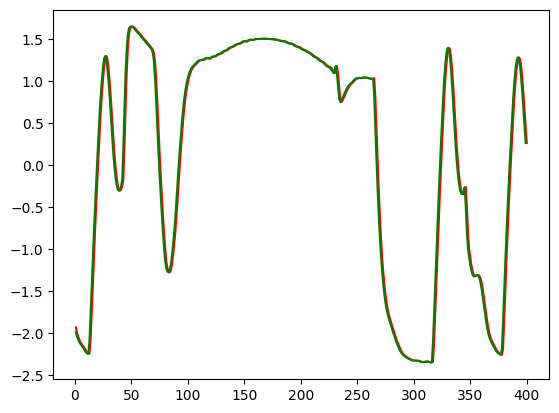

In [10]:
### PLOT TRUE VS PREDICTED VELOCITIES ###

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot( np.arange(1, 401), vx,  color='red') # ground truth
ax1.plot(np.arange(1, 400), np.array(filtered_states)[0], color='green') # predicted velocities
#ax1.plot(np.arange(0, 400), np.array(measurements)[0], color='blue') # measured velocities
#plt.tight_layout()
plt.show()

In [11]:
### Integrating velocities to get position

posx=[0]
posy=[0]
posz=[0]
p1=[0]
p2=[0]
p3=[0]
for i in range (1,399):
    posx.append(filtered_states[0][i]+posx[i-1])
    posy.append(filtered_states[1][i]+posy[i-1])
    posz.append(filtered_states[2][i]+posz[i-1])
    p1.append(measurements[0][i]+p1[i-1])
    p2.append(measurements[1][i]+p2[i-1])
    p3.append(measurements[2][i]+p3[i-1])



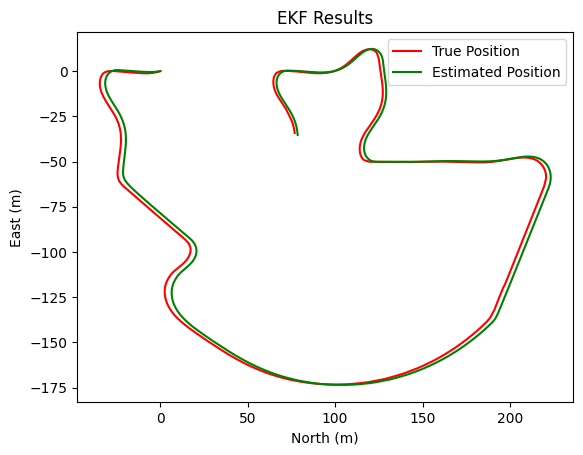

In [12]:
# Plotting position data (2D)

import matplotlib.pyplot as plt

fig = plt.figure()

# Add 2D plot
ax1 = fig.add_subplot()
ax1.plot(north, east, color='red', label='True Position')
ax1.plot(posx, posy, color='green', label='Estimated Position')

# Add labels, title, and legend
ax1.set_xlabel('North (m)')
ax1.set_ylabel('East (m)')
ax1.set_title('EKF Results')
ax1.legend()

plt.show()


SEAMLESS NAVIGATION EXTENDED KALMAN FILTER (TIGHTLY COUPLED)

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import navpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import math

df1 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/IMU_trajectory1.csv', header=0)
df = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/GT_trajectory1.csv', header=0)
df2 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/A-KIT/A-KIT-main/A-KIT-main/Data/Trajectory1/DVL_trajectory1.csv', header=0)

# df1 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/IMU_trajectory1.csv', header=0)
# df = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/GT_trajectory1.csv', header=0)
# df2 = pd.read_csv('C:/Users/sumuk/Documents/IISc Internship/DVL_trajectory1.csv', header=0)

vx = df.iloc[:,4]
vy = df.iloc[:,5]
vz=  df.iloc[:,6]

# vx_dvl = t1_org[:,0]
# vy_dvl = t1_org[:,1]
# vz_dvl = t1_org[:,2]

roll = df.iloc[:,7]
pitch = df.iloc[:,8]
yaw = df.iloc[:,9]

lat = df.iloc[:,2]
long = df.iloc[:,1]
alt = df.iloc[:,3]

ax1=df1.iloc[:,1]
ay1=df1.iloc[:,2]
az1=df1.iloc[:,3]

gyro_x1 = df1.iloc[:,4]
gyro_y1 = df1.iloc[:,5]
gyro_z1 = df1.iloc[:,6]

dvl_x = df2.iloc[:,1]
dvl_y = df2.iloc[:,2]
dvl_z = df2.iloc[:,3]

random.seed(42)

def skew_sym(x):
    a = np.array([[0, -x[2], x[1]],
                 [x[2], 0, -x[0]],
                 [-x[1], x[0], 0]])
    return a


In [14]:
ax=[]
ay=[]
az=[]
gyro_x=[]
gyro_y=[]
gyro_z=[]
for i in range(len(ax1)):
    if i%100==0:
        ax.append(ax1[i])
        ay.append(ay1[i])
        az.append(az1[i])
        gyro_x.append(gyro_x1[i])
        gyro_y.append(gyro_y1[i])
        gyro_z.append(gyro_z1[i])

gyrosc=np.column_stack((gyro_x,gyro_y,gyro_z))
acc=np.column_stack((ax,ay,az))
v_ned = np.column_stack((vx, vy, vz))
v_dvl_tot = np.column_stack((dvl_x, dvl_y, dvl_z))

In [15]:
north=[]
east=[]
down=[]
for i in range (0, len(lat)):
    arr= navpy.lla2ned(lat[i], long[i], alt[i], 0.573337071406794, 0.6089844335224215, -19.859909, latlon_unit='rad', alt_unit='m', model='wgs84')
    north.append(arr[0])
    east.append(arr[1])
    down.append(arr[2])

ned = np.column_stack((north,east,down))

In [16]:

Ro = 6378137
e = 0.0818191908425

def R_N(L):
    x = Ro * (1-(e**2))/ ((1- (e**2)*((math.sin(L))**2))**(1.5))
    return x

def R_E(L):
    x = Ro / ((1- (e**2)*((math.sin(L))**2))**(0.5))
    return x

b_a=0
b_g=0

In [17]:
# Calculate beam direction vectors b1, b2, b3, b4
import numpy as np

pitch_angle = np.radians(30)  
yaw_angles = [np.radians(90 + (i - 1) * 45) for i in range(1, 5)]  

b_vectors = []
for psi in yaw_angles:
    b_i = np.array([
        np.cos(psi) * np.sin(pitch_angle),
        np.sin(psi) * np.sin(pitch_angle),
        np.cos(pitch_angle)
    ])
    b_vectors.append(b_i)

b1, b2, b3, b4 = b_vectors

print("b1:", b1)
print("b2:", b2)
print("b3:", b3)
print("b4:", b4)

b1: [3.06161700e-17 5.00000000e-01 8.66025404e-01]
b2: [-0.35355339  0.35355339  0.8660254 ]
b3: [-5.00000000e-01  6.12323400e-17  8.66025404e-01]
b4: [-0.35355339 -0.35355339  0.8660254 ]


In [18]:
# ESKF
# 3 DIMENSIONAL ##################

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

class KalmanFilter(object):
    def __init__(self, dt, Q_STD, R_STD):
        
        """
        :param INIT_VEL_STD: initial position standard deviation in y-direction
        :param Q_STD: process noise magnitude
        :param R_STD: standard deviation of the measurement
        """

        # INITIALIZATION
       
        self.dt = dt

        self.dx = np.array([0.1, 0.1, 0.1, 2.5*(math.pi/180), 2.5*(math.pi/180), 2.5*(math.pi/180), 15*9.80665*(10**-3), 15*9.80665*(10**-3), 15*9.80665*(10**-3), 15*(math.pi/180), 15*(math.pi/180), 15*(math.pi/180)])

        self.dP = np.diag([0.2,0.2,0.2,1*(math.pi/180),1*(math.pi/180),1*(math.pi/180),30*9.80665*(10**-3),30*9.80665*(10**-3),30*9.80665*(10**-3),1*(math.pi/180),1*(math.pi/180),1*(math.pi/180)])
        
        Ro = 6378137
        w_ie = 7.292115 * 10**(-5)
        phi = roll[0]
        theta=pitch[0]
        si=yaw[0]
        L = lat[0]
        h = alt[0]
        v_n = vx[0]
        v_e = vy[0]
        v_d = vz[0]
        gyro = gyrosc[0]
        accel = acc[0]
        #v_nav = v_ned[0]
        g = np.array([0,0,9.8])
        self.b_a=0
        self.b_g=0
        self.v_dvl = v_dvl_tot[0]
        
        der_r_n = np.array([ [1/(R_N(L)+h),0,0], [0, 1/((R_E(L)+h)*math.cos(L)), 0], [0,0,1]]) @ v_ned[0]
        w_ie_n = np.array([(7.29 * 10**(-5))*math.cos(L), 0, -(7.29 * 10**(-5))*math.sin(L)])
        w_en_n = np.array([der_r_n[1]*math.cos(L), -der_r_n[0], -der_r_n[1]*math.sin(L)])

        self.C_n_b = np.array([[math.cos(theta)*math.cos(si), -math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si)],
            [math.cos(theta)*math.sin(si), math.cos(phi)*math.cos(si)+math.sin(phi)*math.sin(theta)*math.sin(si), -math.sin(phi)*math.cos(si)+math.cos(phi)*math.sin(theta)*math.sin(si)],
            [-math.sin(theta), math.sin(phi)*math.cos(theta), math.cos(phi)*math.cos(theta)]])
        
        # self.v_ins = self.C_n_b @ accel - skew_sym((2*w_ie_n + w_en_n)) @ v_nav + g
        
        self.F_n_11 = -skew_sym((self.C_n_b @gyro))
        self.F_n_21 = -skew_sym((self.C_n_b @ accel))
        self.F_n_12 = np.array([[0, -1/(R_E(L)+h), 0],
                        [1/(R_N(L)+h), 0, 0],
                        [0, math.tan(L)/(R_E(L)+h), 0]])

        self.F_n_22_1 = v_d / (R_N(L)+h)
        self.F_n_22_2 = - ((2*v_e*math.tan(L))/(R_E(L)+h)) - 2*w_ie*math.sin(L)
        self.F_n_22_3 = v_n / (R_N(L)+h)
        self.F_n_22_4 = (v_e * math.tan(L)/(R_E(L)+h)) + 2*w_ie*math.sin(L)
        self.F_n_22_5 = ((v_e * math.tan(L) + v_d)/(R_E(L)+h))
        self.F_n_22_6 = (v_e/(R_E(L)+h)) + 2*w_ie*math.cos(L)
        self.F_n_22_7 = - 2*v_n/(R_N(L)+h)
        self.F_n_22_8 = - 2*v_e/(R_N(L)+h) - 2*w_ie*math.cos(L)
        self.F_n_22_9 = 0
        
        self.O_3 = np.zeros((3,3))

        self.F_n_22 = np.array([[self.F_n_22_1, self.F_n_22_2, self.F_n_22_3],
                   [self.F_n_22_4, self.F_n_22_5, self.F_n_22_6],
                   [self.F_n_22_7, self.F_n_22_8, self.F_n_22_8]])
        
        F1 = np.column_stack((self.F_n_22, self.F_n_21, self.O_3, self.C_n_b))
        F2 = np.column_stack((self.F_n_12, self.F_n_11, self.C_n_b, self.O_3))
        F3 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))
        F4 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))

        self.F = np.row_stack((F1, F2, F3, F4))
        
        G1 = np.column_stack((self.O_3, self.C_n_b, self.O_3, self.O_3))
        G2 = np.column_stack((self.C_n_b,  self.O_3, self.O_3, self.O_3))
        G3 = np.column_stack((self.O_3, self.O_3, np.ones((3,3)), self.O_3))
        G4 = np.column_stack((self.O_3, self.O_3, self.O_3, np.ones((3,3))))

        self.G = np.row_stack((G1, G2, G3, G4))
        
        self.n = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

        phi_1=np.column_stack((np.diag([1,1,1]) + self.dt * self.F_n_22, self.dt * self.F_n_21, self.O_3, self.C_n_b*self.dt))
        phi_2=np.column_stack((self.dt * self.F_n_12, np.diag([1,1,1]) + self.dt * self.F_n_11, self.C_n_b*self.dt, self.O_3))
        phi_3=np.column_stack((self.O_3, self.O_3, np.diag([1,1,1]), self.O_3))
        phi_4=np.column_stack((self.O_3, self.O_3, self.O_3, np.diag([1,1,1])))

        self.phi_ins = np.row_stack((phi_1, phi_2, phi_3, phi_4))

        self.H1 = np.column_stack((b1.T @ self.C_n_b.T , -b1.T @ self.C_n_b.T @ skew_sym(v_ned[0]), np.zeros(3).T, np.zeros(3).T))
        self.H2 = np.column_stack((b2.T @ self.C_n_b.T , -b2.T @ self.C_n_b.T @ skew_sym(v_ned[0]), np.zeros(3).T, np.zeros(3).T))
        self.H3 = np.column_stack((b3.T @ self.C_n_b.T , -b3.T @ self.C_n_b.T @ skew_sym(v_ned[0]), np.zeros(3).T, np.zeros(3).T))
        self.H4 = np.column_stack((b4.T @ self.C_n_b.T , -b4.T @ self.C_n_b.T @ skew_sym(v_ned[0]), np.zeros(3).T, np.zeros(3).T))

        self.H = np.row_stack((self.H1, self.H2, self.H3, self.H4))
        
        self.Q = np.diag([Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2, Q_STD ** 2])

        self.R = np.diag([R_STD ** 2, R_STD ** 2, R_STD ** 2, R_STD ** 2]) 
        
        self.term1 = self.phi_ins @ self.G @ self.Q @ self.G.T
        self.term2 = self.G @ self.Q @ self.G.T @ self.G.T

        self.Q_k_minus_1 = 0.5 * (self.term1 + self.term2) * 1

    # PREDICTION STEP
    def predict(self):

        self.dx = np.dot(self.phi_ins, self.dx) 

        self.dP = np.dot(self.phi_ins, np.dot(self.dP, (self.phi_ins).T)) + self.Q_k_minus_1

        pred_state = self.dx

        return pred_state

    # UPDATE STEP
    def update(self, v_nav, i):
        
        self.dz1 = b1.T @ self.C_n_b.T @ (self.dx[0:3]) -  b1.T @ self.C_n_b.T @ skew_sym(v_nav) @ self.dx[3:6]
        self.dz2 = b2.T @ self.C_n_b.T @ (self.dx[0:3]) -  b2.T @ self.C_n_b.T @ skew_sym(v_nav) @ self.dx[3:6]
        self.dz3 = b3.T @ self.C_n_b.T @ (self.dx[0:3]) -  b3.T @ self.C_n_b.T @ skew_sym(v_nav) @ self.dx[3:6]
        self.dz4 = b4.T @ self.C_n_b.T @ (self.dx[0:3]) -  b4.T @ self.C_n_b.T @ skew_sym(v_nav) @ self.dx[3:6]

        self.dz = np.row_stack((self.dz1, self.dz2, self.dz3, self.dz4))
        self.S = np.dot(self.H.T, np.dot(self.dP, (self.H))) + self.R

        self.K = np.dot(self.dP, np.dot((self.H), np.linalg.inv(self.S)))        

        I = np.eye(12)

        self.dx =  np.dot(self.K, self.dz)

        self.dx = self.dx.T[0]

        self.dP = np.dot((I - np.dot(self.K, self.H.T)), self.dP)

        # Update values and equations for next time instant
        Ro = 6378137
        w_ie = 7.292115 * 10**(-5)
        phi = roll[i]
        theta=pitch[i]
        si=yaw[i]
        L = lat[i]
        h = alt[i]
        v_n = v_nav[0]
        v_e = v_nav[1]
        v_d = v_nav[2]
        gyro = gyrosc[i]
        accel = acc[i]
        self.v_dvl = v_dvl_tot[i]

        der_r_n = np.array([ [1/(R_N(L)+h),0,0], [0, 1/((R_E(L)+h)*math.cos(L)), 0], [0,0,1]]) @ v_nav
        w_ie_n = np.array([(7.29 * 10**(-5))*math.cos(L), 0, -(7.29 * 10**(-5))*math.sin(L)])
        w_en_n = np.array([der_r_n[1]*math.cos(L), -der_r_n[0], -der_r_n[1]*math.sin(L)])
        

        self.C_n_b = np.array([[math.cos(theta)*math.cos(si), -math.cos(phi)*math.sin(si)+math.sin(phi)*math.sin(theta)*math.cos(si), math.sin(phi)*math.sin(si)+math.cos(phi)*math.sin(theta)*math.cos(si)],
            [math.cos(theta)*math.sin(si), math.cos(phi)*math.cos(si)+math.sin(phi)*math.sin(theta)*math.sin(si), -math.sin(phi)*math.cos(si)+math.cos(phi)*math.sin(theta)*math.sin(si)],
            [-math.sin(theta), math.sin(phi)*math.cos(theta), math.cos(phi)*math.cos(theta)]])
        
        self.F_n_11 = -skew_sym((self.C_n_b @gyro))
        self.F_n_21 = -skew_sym((self.C_n_b @ accel))
        self.F_n_12 = np.array([[0, -1/(R_E(L)+h), 0],
                        [1/(R_N(L)+h), 0, 0],
                        [0, math.tan(L)/(R_E(L)+h), 0]])

        self.F_n_22_1 = v_d / (R_N(L)+h)
        self.F_n_22_2 = - ((2*v_e*math.tan(L))/(R_E(L)+h)) - 2*w_ie*math.sin(L)
        self.F_n_22_3 = v_n / (R_N(L)+h)
        self.F_n_22_4 = (v_e * math.tan(L)/(R_E(L)+h)) + 2*w_ie*math.sin(L)
        self.F_n_22_5 = ((v_e * math.tan(L) + v_d)/(R_E(L)+h))
        self.F_n_22_6 = (v_e/(R_E(L)+h)) + 2*w_ie*math.cos(L)
        self.F_n_22_7 = - 2*v_n/(R_N(L)+h)
        self.F_n_22_8 = - 2*v_e/(R_N(L)+h) - 2*w_ie*math.cos(L)
        self.F_n_22_9 = 0
        
        self.O_3 = np.zeros((3,3))

        self.F_n_22 = np.array([[self.F_n_22_1, self.F_n_22_2, self.F_n_22_3],
                   [self.F_n_22_4, self.F_n_22_5, self.F_n_22_6],
                   [self.F_n_22_7, self.F_n_22_8, self.F_n_22_8]])
        
        F1 = np.column_stack((self.F_n_22, self.F_n_21, self.O_3, self.C_n_b))
        F2 = np.column_stack((self.F_n_12, self.F_n_11, self.C_n_b, self.O_3))
        F3 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))
        F4 = np.column_stack((self.O_3, self.O_3, self.O_3, self.O_3))

        self.F = np.row_stack((F1, F2, F3, F4))
        
        G1 = np.column_stack((self.O_3, self.C_n_b, self.O_3, self.O_3))
        G2 = np.column_stack((self.C_n_b,  self.O_3, self.O_3, self.O_3))
        G3 = np.column_stack((self.O_3, self.O_3, np.ones((3,3)), self.O_3))
        G4 = np.column_stack((self.O_3, self.O_3, self.O_3, np.ones((3,3))))

        self.G = np.row_stack((G1, G2, G3, G4))
        
        self.n = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

        phi_1=np.column_stack((np.diag([1,1,1]) + self.dt * self.F_n_22, self.dt * self.F_n_21, self.O_3, self.C_n_b*self.dt))
        phi_2=np.column_stack((self.dt * self.F_n_12, np.diag([1,1,1]) + self.dt * self.F_n_11, self.C_n_b*self.dt, self.O_3))
        phi_3=np.column_stack((self.O_3, self.O_3, np.diag([1,1,1]), self.O_3))
        phi_4=np.column_stack((self.O_3, self.O_3, self.O_3, np.diag([1,1,1])))

        self.phi_ins = np.row_stack((phi_1, phi_2, phi_3, phi_4))

        self.term1 = self.phi_ins @ self.G @ self.Q @ self.G.T
        self.term2 = self.G @ self.Q @ self.G.T @ self.G.T

        # Compute Q_{k-1}
        self.Q_k_minus_1 = 0.5 * (self.term1 + self.term2) * 1

        self.H1 = np.column_stack((b1.T @ self.C_n_b.T , -b1.T @ self.C_n_b.T @ skew_sym(v_nav), np.zeros(3).T, np.zeros(3).T))
        self.H2 = np.column_stack((b2.T @ self.C_n_b.T , -b2.T @ self.C_n_b.T @ skew_sym(v_nav), np.zeros(3).T, np.zeros(3).T))
        self.H3 = np.column_stack((b3.T @ self.C_n_b.T , -b3.T @ self.C_n_b.T @ skew_sym(v_nav), np.zeros(3).T, np.zeros(3).T))
        self.H4 = np.column_stack((b4.T @ self.C_n_b.T , -b4.T @ self.C_n_b.T @ skew_sym(v_nav), np.zeros(3).T, np.zeros(3).T))

        self.H = np.row_stack((self.H1, self.H2, self.H3, self.H4))

        # Update Equations
        v_ekf = v_nav - self.dx[0:3]
        self.C_n_b = (np.eye(3) - skew_sym(self.dx[3:6])) @ self.C_n_b
        self.b_a = self.b_a + self.dx[6:9]
        self.b_g = self.b_g + self.dx[9:12]

        return v_ekf, self.dx, self.dP


In [19]:
np.random.seed(0)

# Kalman filter parameters
dt = 1 # Sampling time

Q_STD = 0.005 # Acceleration standard deviation
R_STD = 8 # Measurement position standard deviation

measurements = np.row_stack((vx, vy, vz))
#measurements = measurements + np.random.normal(-0.18, 0.18, size=measurements.shape)

# Kalman filter initialization
kf = KalmanFilter(dt, Q_STD, R_STD)

# Lists to store filtered states
filtered_states = []
e1=[]
v_ins_list=[]
cov_x=[]
cov_y=[]
cov_z=[]
# Perform prediction and update steps for each measurement
for i in range(1, 400):
    # Prediction step
    pred_state = kf.predict()

    # Update step
    updated_state, error, cov_1 = kf.update(measurements.T[i],i)
    e1.append(error)
    cov_x.append(math.sqrt(cov_1[0][0]))
    cov_y.append(math.sqrt(cov_1[1][1]))
    cov_z.append(math.sqrt(cov_1[2][2]))

    # Store the filtered state
    filtered_states.append(updated_state)
# Convert filtered states to NumPy array
filtered_states = np.array(filtered_states).T

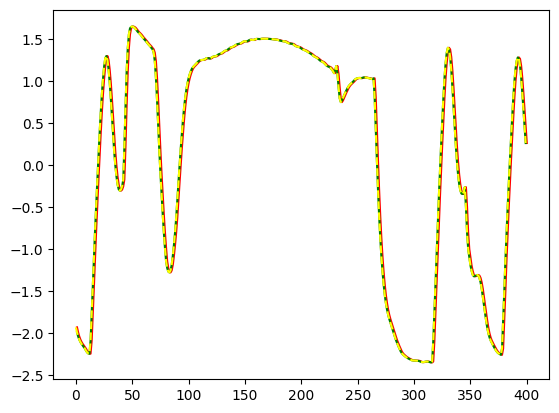

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot( np.arange(1, 401), vx,  color='red') # ground truth velocities
ax1.plot(np.arange(1, 400), np.array(filtered_states)[0], color='green') # predicted velocities
#ax1.plot(np.arange(0, 400), np.array(measurements)[0], color='yellow', linestyle='--') # measured velocities

#plt.tight_layout()
plt.show()

In [22]:
posx=[0]
posy=[0]
posz=[0]
p1=[0]
p2=[0]
p3=[0]
for i in range (1,399):
    posx.append(filtered_states[0][i]+posx[i-1])
    posy.append(filtered_states[1][i]+posy[i-1])
    posz.append(filtered_states[2][i]+posz[i-1])
    p1.append(measurements[0][i]+p1[i-1])
    p2.append(measurements[1][i]+p2[i-1])
    p3.append(measurements[2][i]+p3[i-1])



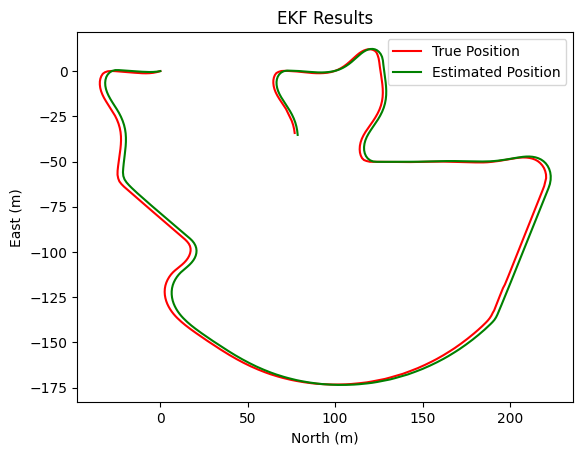

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

# Add 2D plot
ax1 = fig.add_subplot()
ax1.plot(north, east, color='red', label='True Position')
ax1.plot(posx, posy, color='green', label='Estimated Position')

# Add labels, title, and legend
ax1.set_xlabel('North (m)')
ax1.set_ylabel('East (m)')
ax1.set_title('EKF Results')
ax1.legend()

plt.show()
